In [2]:
import glob
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

names = []
dfs = []

for file in glob.glob("/projects/gmihybridsys/dguittet/dispatches/dispatches/models/renewables_case/wind_battery_results_*.csv"):
    if 'eagle' in file or 'uncertainty' not in file:
        continue
    name = Path(file).stem.split("uncertainty_w_")[1]
    names.append(name)
    df = pd.read_csv(file)
    df.set_index("DateTime")
    dfs.append(df)

print(names)

['15_reserves_1000_shortfall_RT', '10_reserves_1000_shortfall_RT', '10_reserves_500_shortfall_RT', '15_reserves_1000_shortfall_DA', '10_reserves_500_shortfall_DA', '15_reserves_500_shortfall_DA', '10_reserves_1000_shortfall_DA', '15_reserves_500_shortfall_RT']


In [98]:
def plot_lmps_vs_time(max_charge_lmp, min_discharge_lmp, FECs):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs over Time
    """
    max_charge_lmp = np.array(max_charge_lmp)
    min_discharge_lmp = np.array(min_discharge_lmp)

    fig, ax = plt.subplots(1, 1, figsize=(24, 3))
    ax.plot(max_charge_lmp[0:], label="Max Charge LMP")
    ax.plot(min_discharge_lmp[0:], label="Min Discharge LMP")
    ax.set_xlabel("Day")
    ax.set_ylabel("$/MWh")
    ax.legend()
    # ax11 = ax.twinx()
    # ax11.plot(FECs, color='k', alpha=0.5, linestyle="--", label="FECs")
    # ax11.legend(loc='lower right')
    fig.suptitle("LMPs per Interval vs Time")
    fig.tight_layout()


def plot_lmps_sorted(max_charge_lmp, min_discharge_lmp, ax):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs Sorted by increasing order
    """
    max_charge_lmp_sorted = np.sort(max_charge_lmp)
    min_discharge_lmp_sorted = np.sort(min_discharge_lmp)

    ax.scatter(range(len(max_charge_lmp_sorted)), max_charge_lmp_sorted, label="Max Charge LMP", alpha=0.4)
    ax.scatter(range(len(min_discharge_lmp_sorted)), min_discharge_lmp_sorted, label="Min Discharge LMP", alpha=0.4)
    ax.set_xlabel("N")
    ax.set_ylabel("$/MWh")
    ax.legend()
    ax.set_title("LMPs per Interval in Increasing Order")


def plot_lmps_vs_FECs(max_charge_lmp, min_discharge_lmp, FECs, ax):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs vs that Interval's number of Full Energy Cycles
    """
    bid_curve = list(zip(max_charge_lmp, FECs))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Max Charge LMP", alpha=0.4)
    ax.set_xlabel("FECs")
    ax.set_xlim((0, None))

    bid_curve = list(zip(min_discharge_lmp, FECs))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Min Discharge LMP", alpha=0.4)
    ax.set_ylim((-5, max(min_discharge_lmp) + 5))
    ax.legend()
    ax.set_title("LMPs per Interval vs Battery Full Energy Cycles")


def plot_lmps_vs_SOC(max_charge_lmp, min_discharge_lmp, charge_SOC, discharge_SOC, ax):
    """
    Plots each Time Interval's Max Charge LMPs and Min Discharge LMPs vs the average SOCs at start time of charges or discharges
    """
    bid_curve = list(zip(max_charge_lmp, charge_SOC))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Max Charge LMP", alpha=0.4)
    ax.set_xlabel("SOC at which to Charge or Discharge")

    bid_curve = list(zip(min_discharge_lmp, discharge_SOC))
    bid_curve.sort()
    bid_curve = np.array(bid_curve)
    ax.scatter(bid_curve[:, 1], bid_curve[:, 0], label="Min Discharge LMP", alpha=0.4)
    ax.set_ylim((-5, max(min_discharge_lmp) + 5))
    ax.set_xlim((0, 1))
    ax.legend()
    ax.set_title("LMPs per Interval vs Battery Starting SOC")


In [99]:
def all_batt_plots(res_df, title):
    fig = plt.figure(constrained_layout=True, figsize=(24, 12))
    fig.suptitle(title)
    subfigs = fig.subfigures(nrows=3, ncols=1)

    horizon_hrs = (1, 8, 24)

    batt_mwh = res_df['batt_cap'].unique()[0] * 4

    for c, horizon in enumerate(horizon_hrs):
        subfigs[c].suptitle(f"{horizon} hr Horizon Interval")
        axs = subfigs[c].subplots(nrows=1, ncols=3)

        intervals = int(len(res_df) / horizon)

        max_charge_lmp = []
        charge_SOC = []
        min_discharge_lmp = []
        discharge_SOC = []
        FECs = []

        # days = 2
        for d in range(intervals):
            start = d * horizon
            end = min(start + horizon, len(res_df))
            df = res_df[start:end]
            charging = df[df['wind_to_batt_mw'] > 0.01]
            discharging = df[df['batt_to_grid_mw'] > 0.01]
            charging_lmps = charging['lmp'].values
            discharging_lmps = discharging['lmp'].values
            charging_mws = charging['wind_to_batt_mw'].values
            discharging_mws = discharging['batt_to_grid_mw'].values

            charge_lmp = max(charging_lmps) if len(charging_lmps) > 0 else 0
            discharge_lmp = min(discharging_lmps) if len(discharging_lmps) > 0 else 0

            charge_steps = charging.index - 1
            discharge_steps = discharging.index - 1
            charging_socs = res_df[res_df.index.isin(charge_steps)]['soc'].values / batt_mwh * 1e-3
            discharging_socs = res_df[res_df.index.isin(discharge_steps)]['soc'].values / batt_mwh * 1e-3
            
            if charge_lmp > discharge_lmp:
                charge_lmp = discharge_lmp = (charge_lmp + discharge_lmp) / 2
        
            FEC = -1
            if len(charging):
                charge_SOC.append(charging_socs.mean())
                max_charge_lmp.append(charge_lmp)
                FEC = sum((df['wind_to_batt_mw']/ (batt_mwh)).values[0:horizon])
            else:
                charge_SOC.append(-1)
                max_charge_lmp.append(0)

            if len(discharging):
                discharge_SOC.append(discharging_socs.mean())
                min_discharge_lmp.append(discharge_lmp)
                FEC = sum((df['batt_to_grid_mw']/ (batt_mwh)).values[0:horizon])
            else:
                discharge_SOC.append(-1)
                min_discharge_lmp.append(0)
            FECs.append(FEC)

        plot_lmps_sorted(max_charge_lmp, min_discharge_lmp, axs[0])
        plot_lmps_vs_FECs(max_charge_lmp, min_discharge_lmp, FECs, axs[1])
        plot_lmps_vs_SOC(max_charge_lmp, min_discharge_lmp, charge_SOC, discharge_SOC, axs[2])

        plot_lmps_vs_time(max_charge_lmp, min_discharge_lmp, FECs)
        plt.suptitle(f"{horizon} hr Horizon Interval")


/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_49078/1988439423.py:47: RuntimeWarning: Mean of empty slice.
  charge_SOC.append(charging_socs.mean())
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


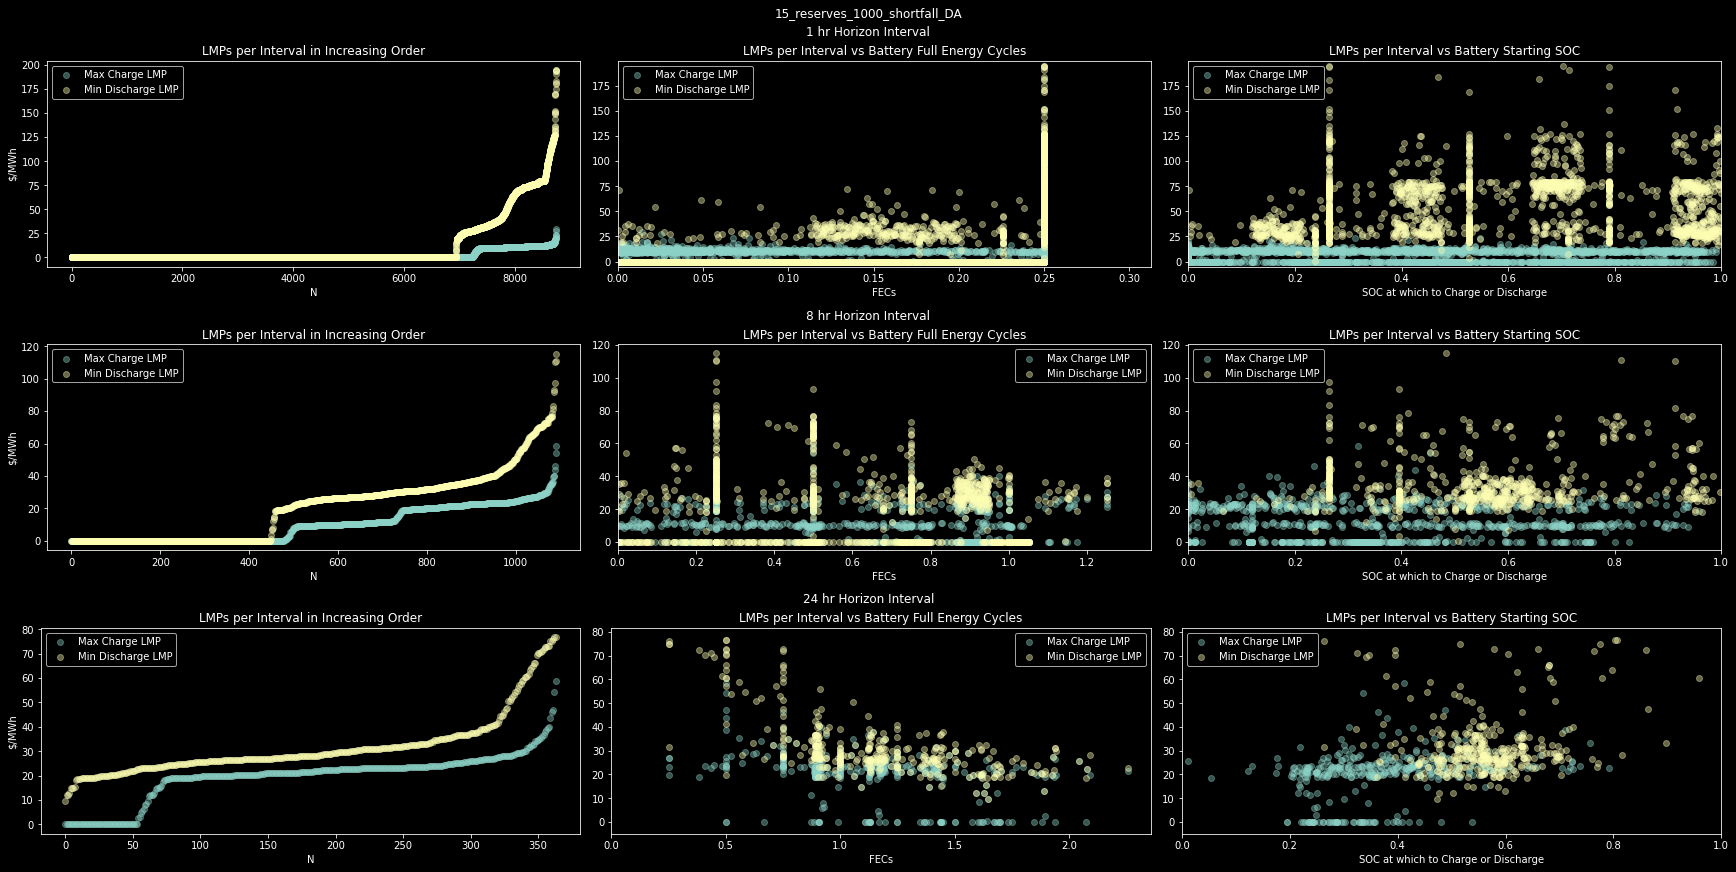

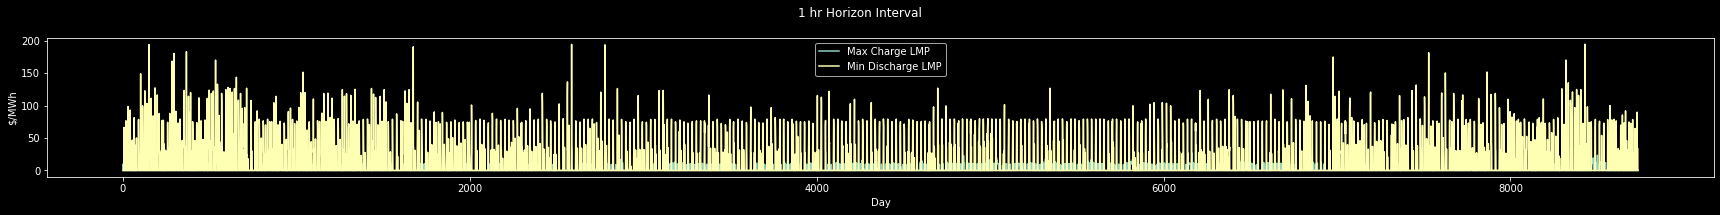

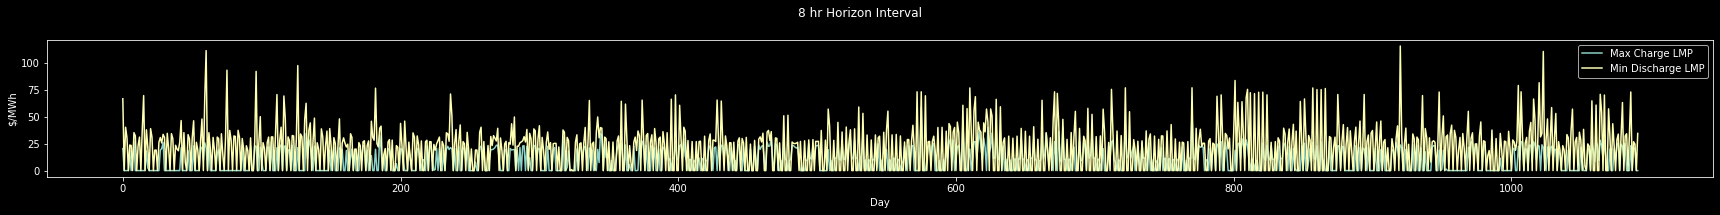

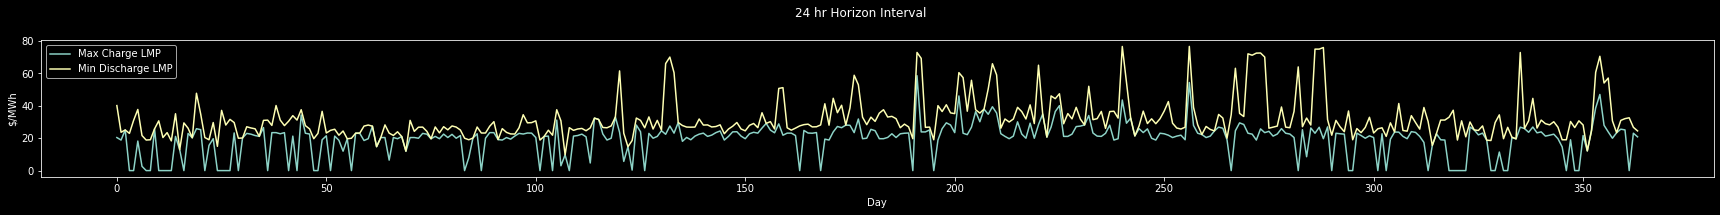

In [50]:
all_batt_plots(dfs[0], names[0])

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_23589/1988439423.py:47: RuntimeWarning: Mean of empty slice.
  charge_SOC.append(charging_socs.mean())
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


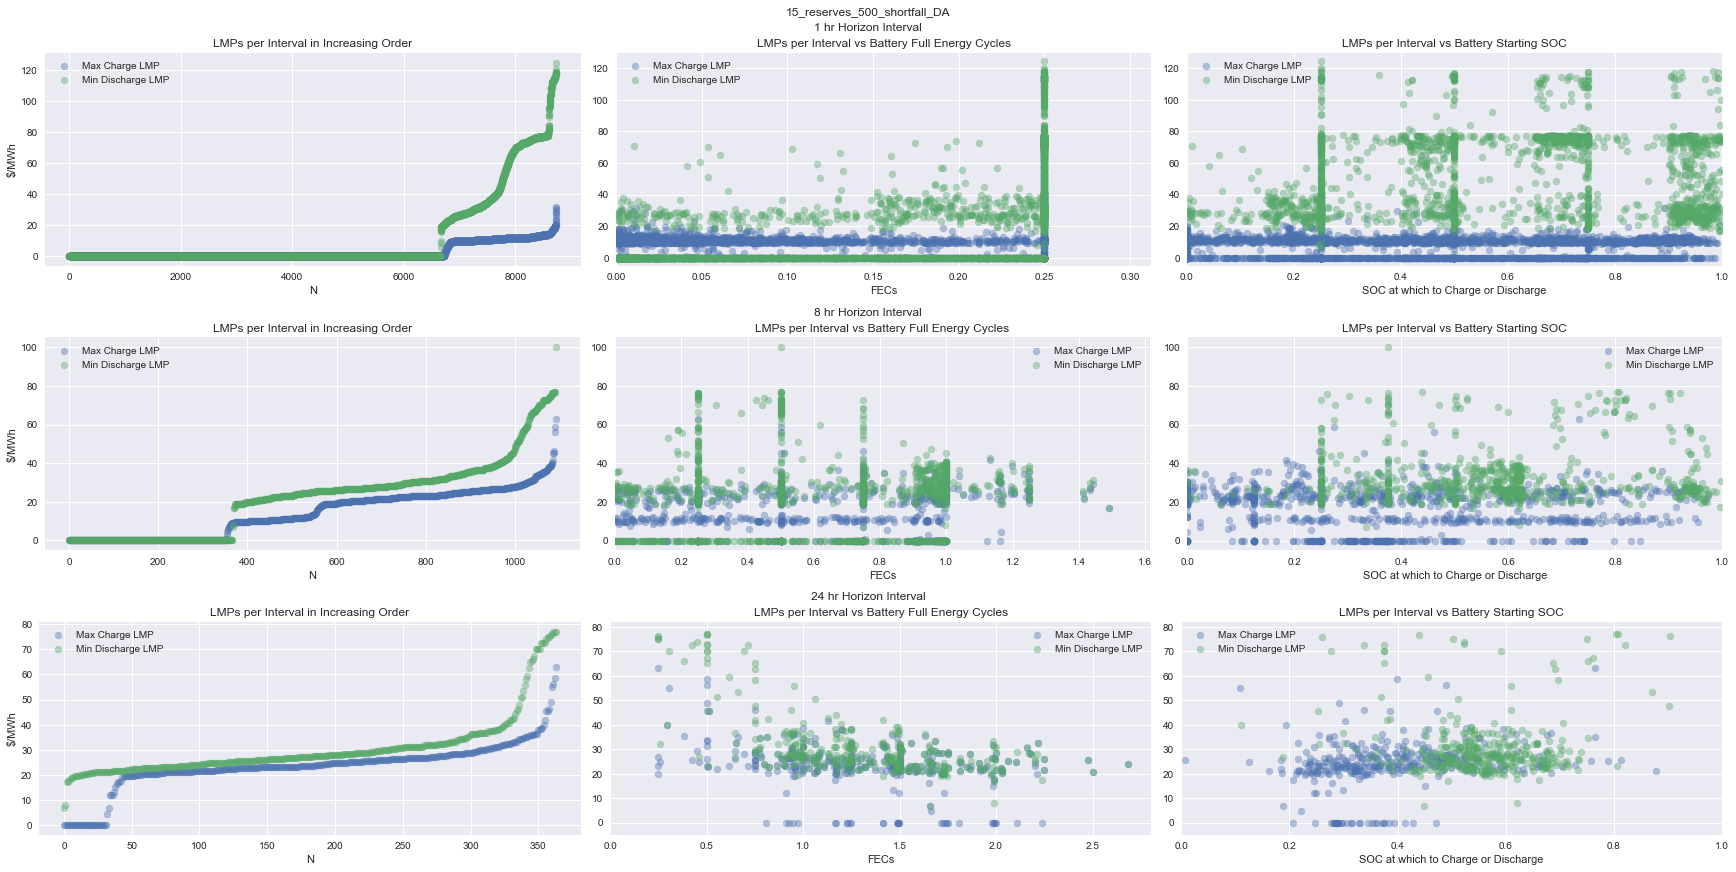

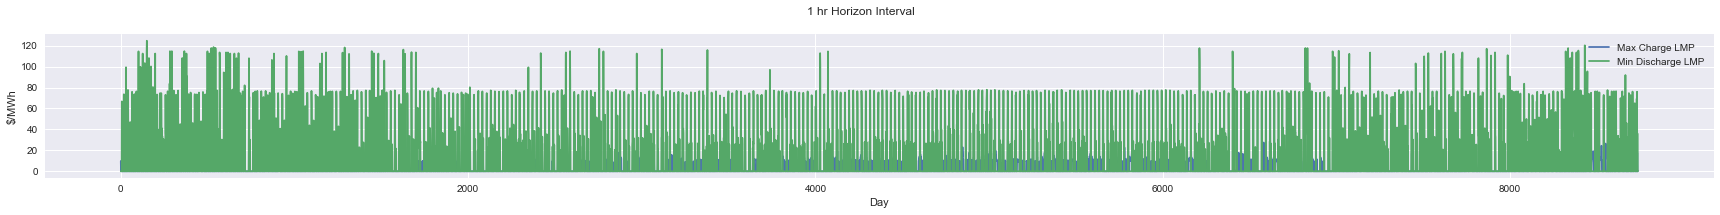

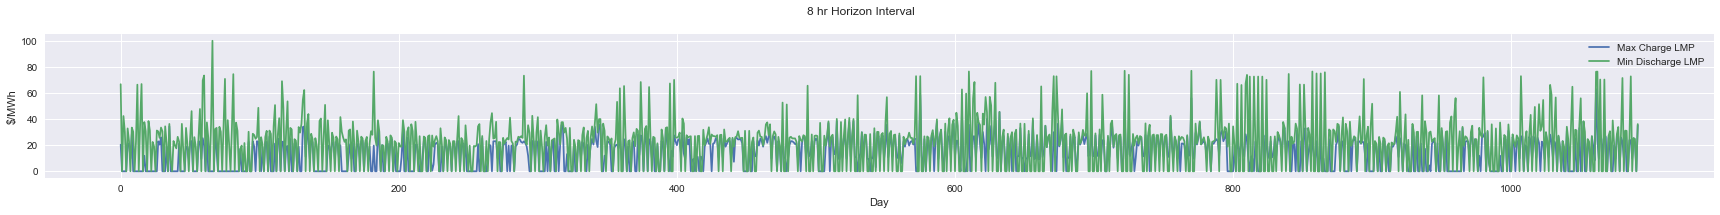

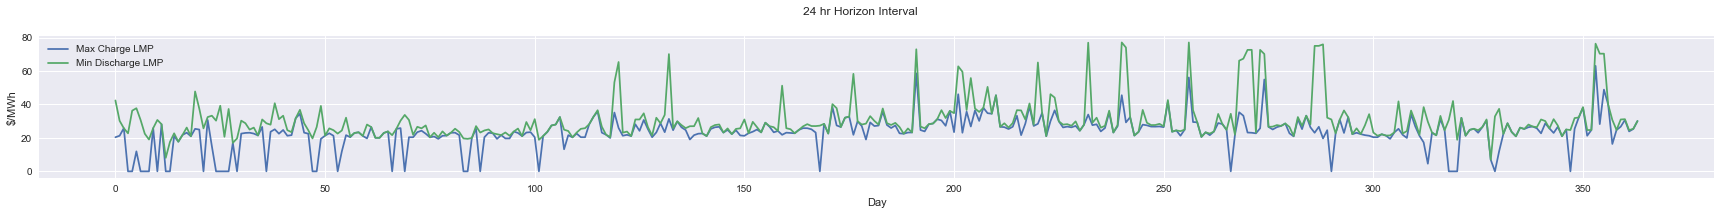

In [100]:
all_batt_plots(dfs[1], names[1])

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_49078/1988439423.py:47: RuntimeWarning: Mean of empty slice.
  charge_SOC.append(charging_socs.mean())
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


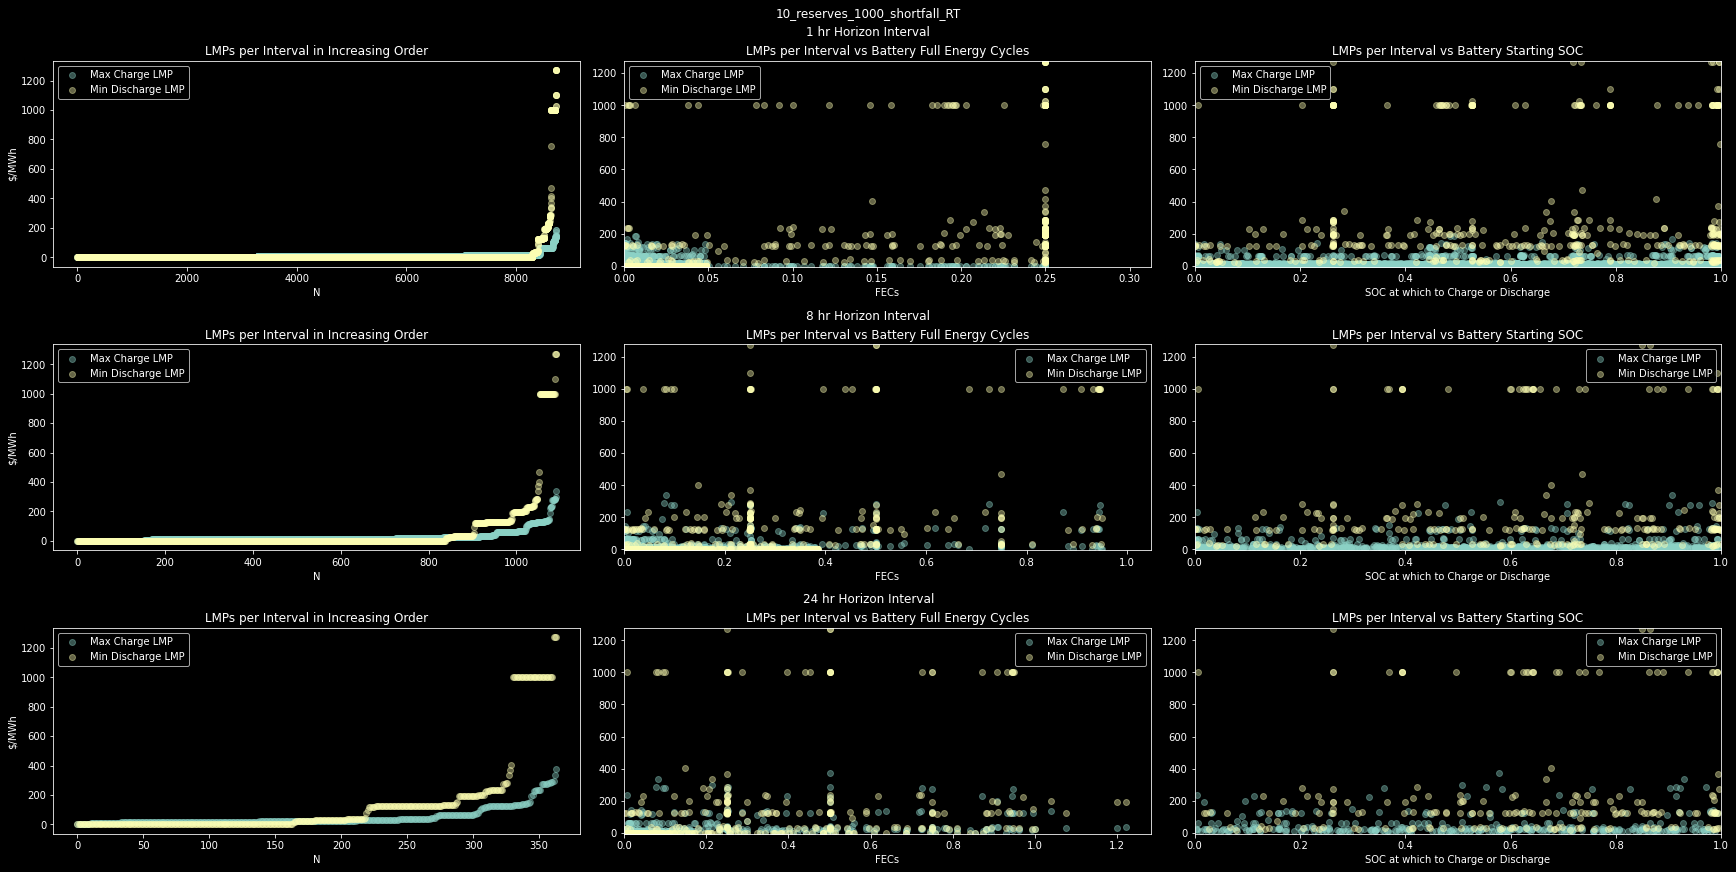

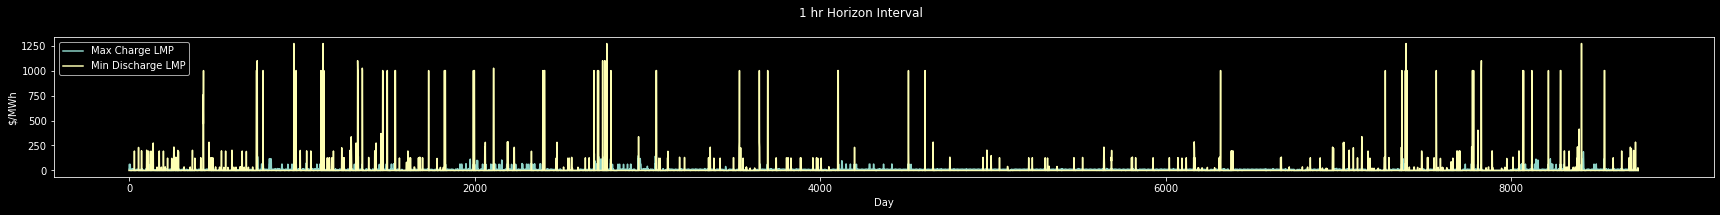

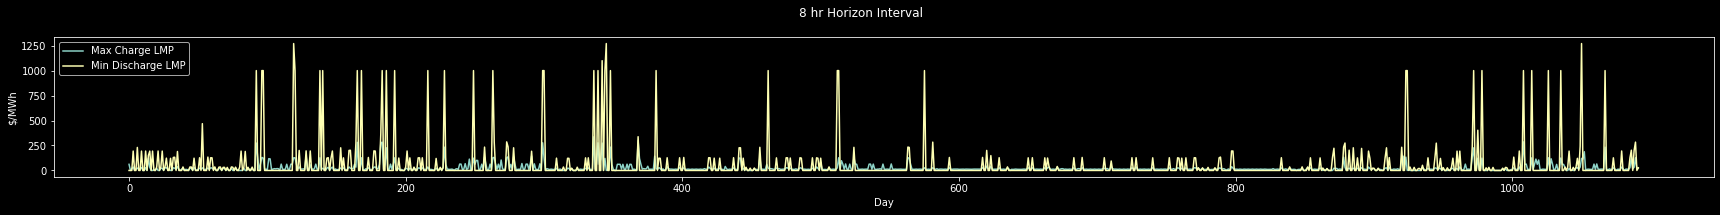

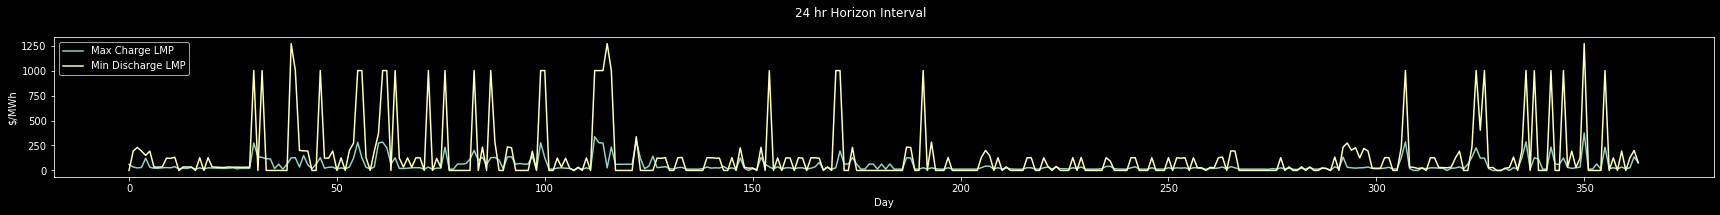

In [52]:
all_batt_plots(dfs[2], names[2])

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_49078/1988439423.py:47: RuntimeWarning: Mean of empty slice.
  charge_SOC.append(charging_socs.mean())
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


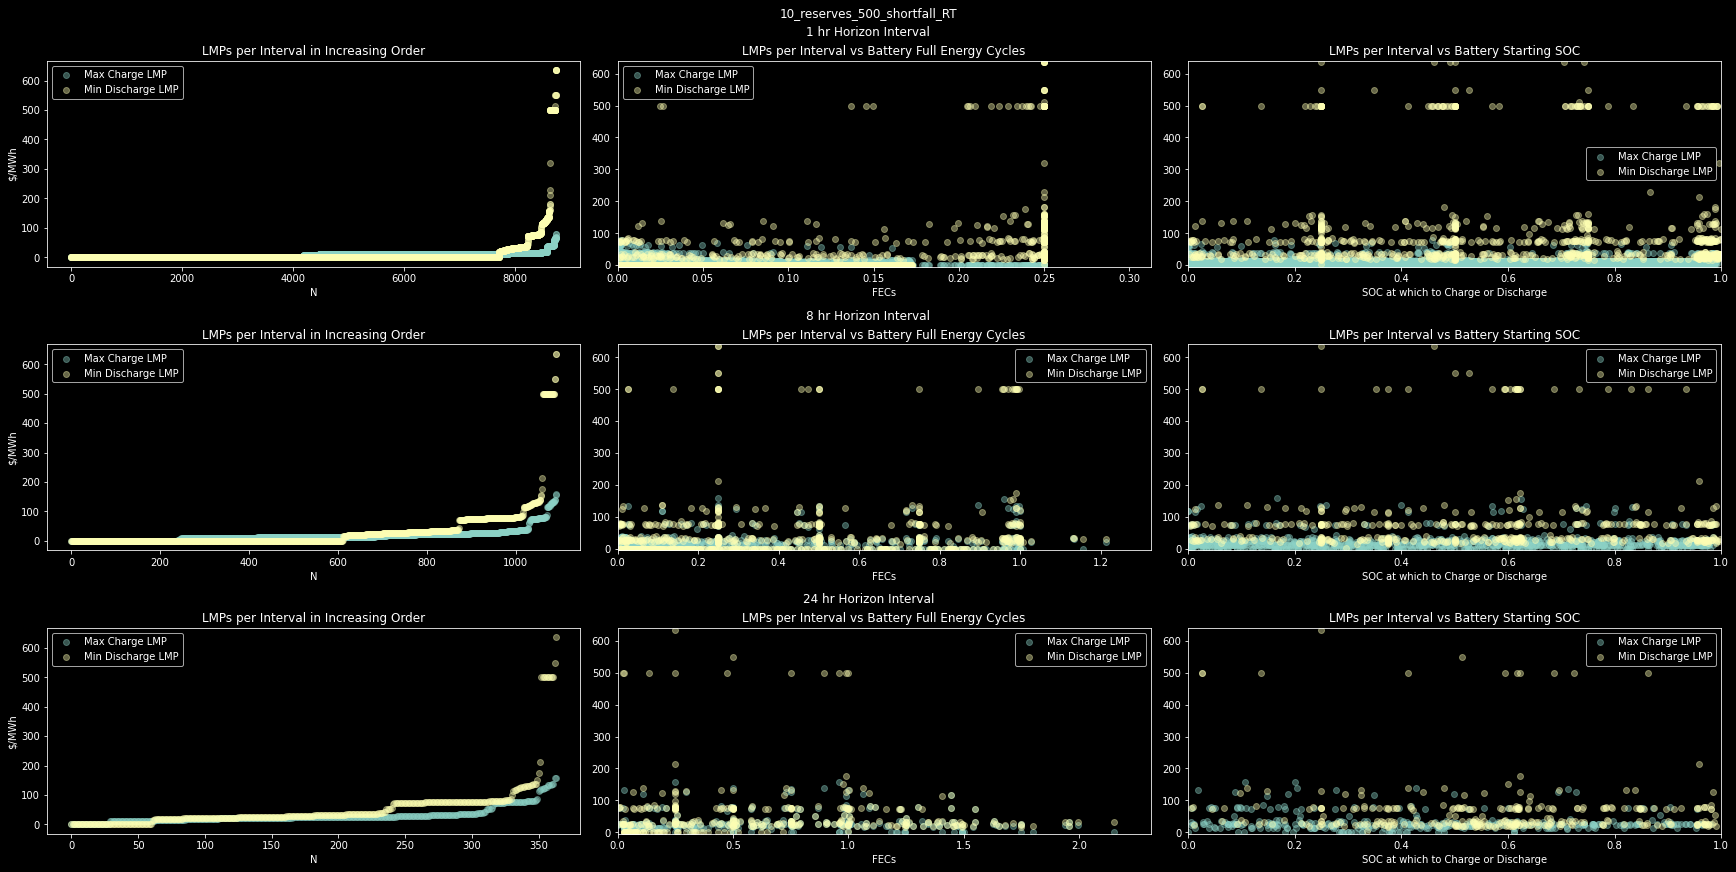

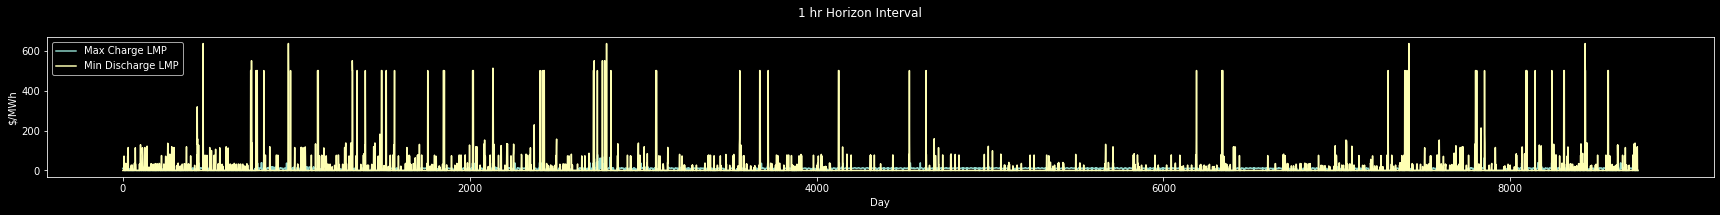

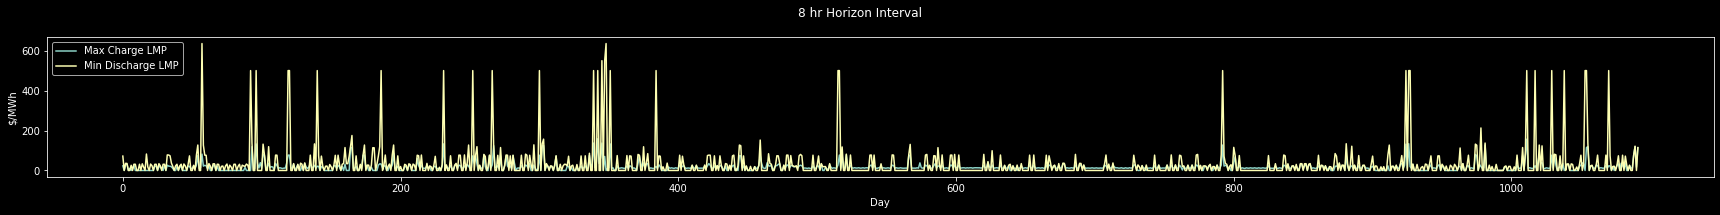

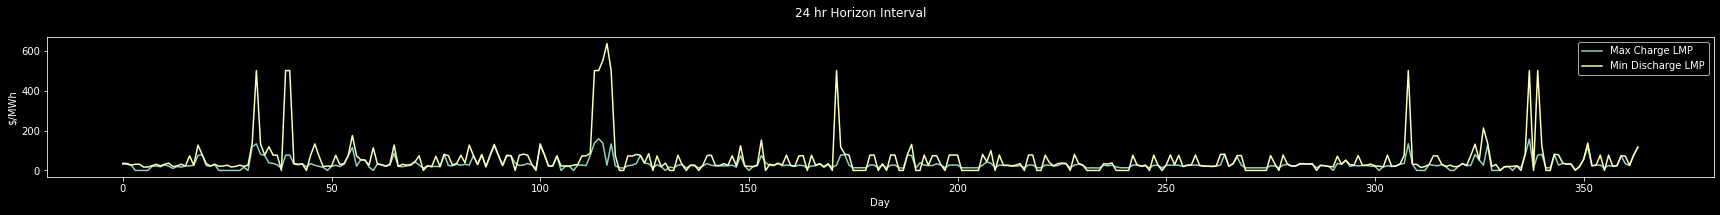

In [53]:
all_batt_plots(dfs[3], names[3])

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_49078/1988439423.py:47: RuntimeWarning: Mean of empty slice.
  charge_SOC.append(charging_socs.mean())
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


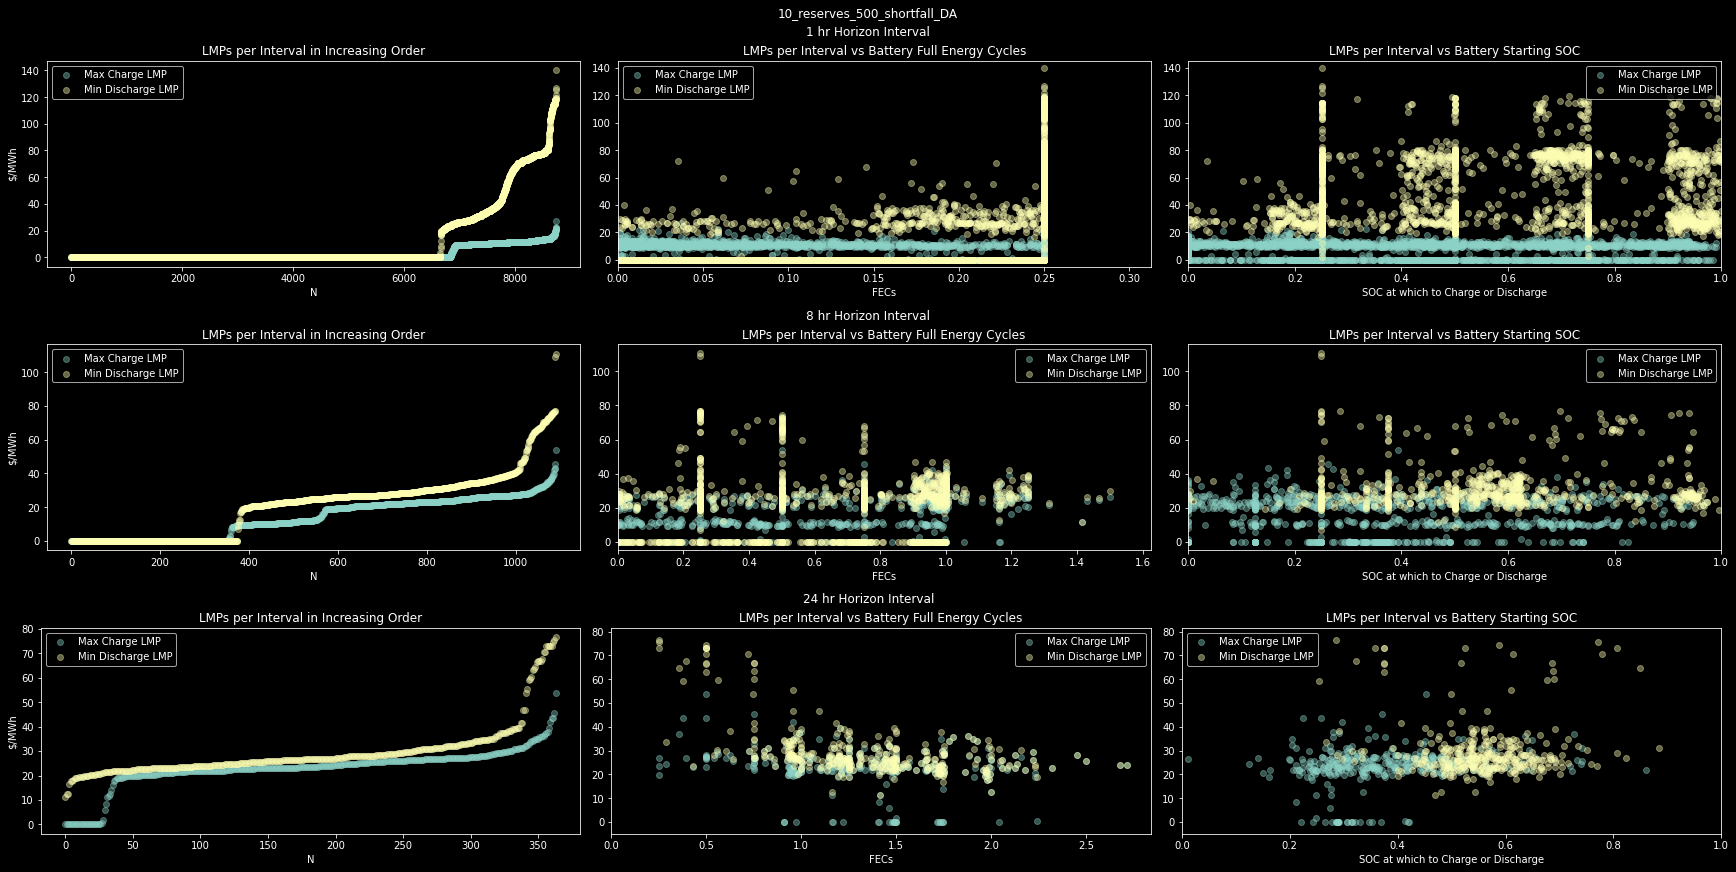

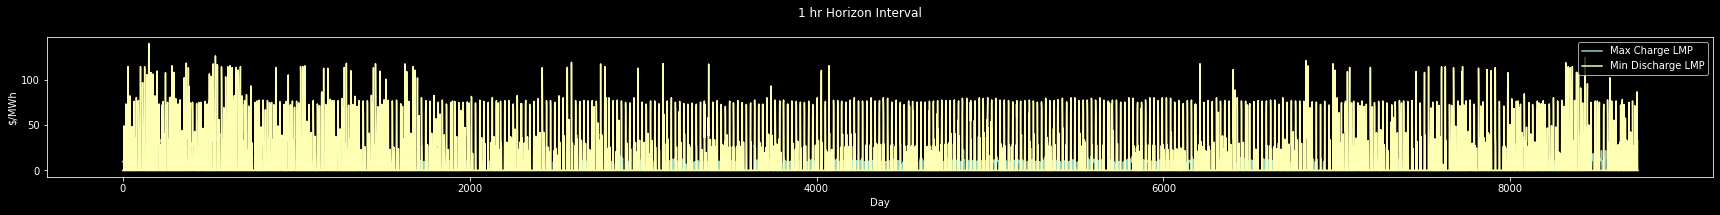

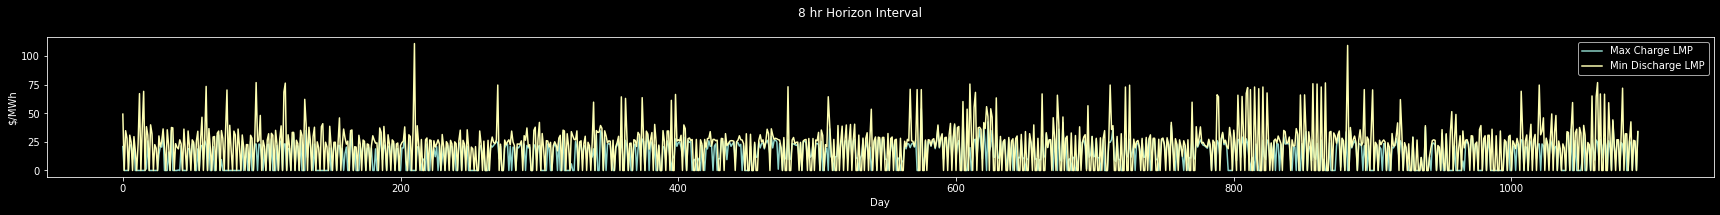

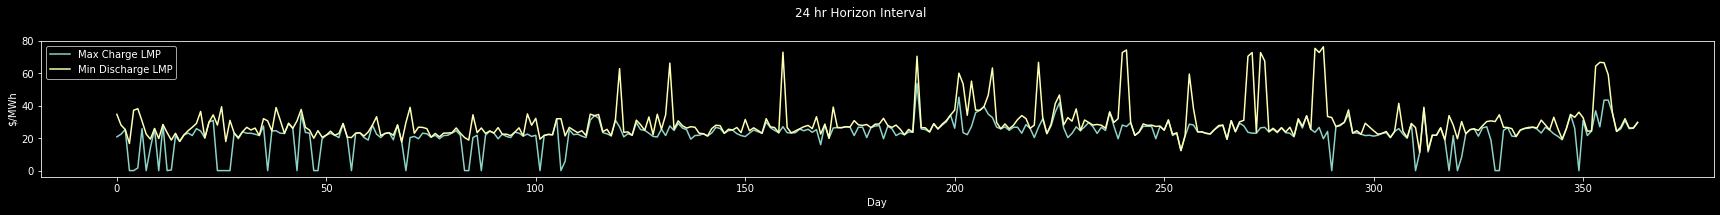

In [54]:
all_batt_plots(dfs[4], names[4])

/var/folders/yh/xvlf1svn0xq6r2l4hzsggz2xt3qfdr/T/ipykernel_49078/1988439423.py:47: RuntimeWarning: Mean of empty slice.
  charge_SOC.append(charging_socs.mean())
/Users/dguittet/miniconda3/envs/dispatches/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


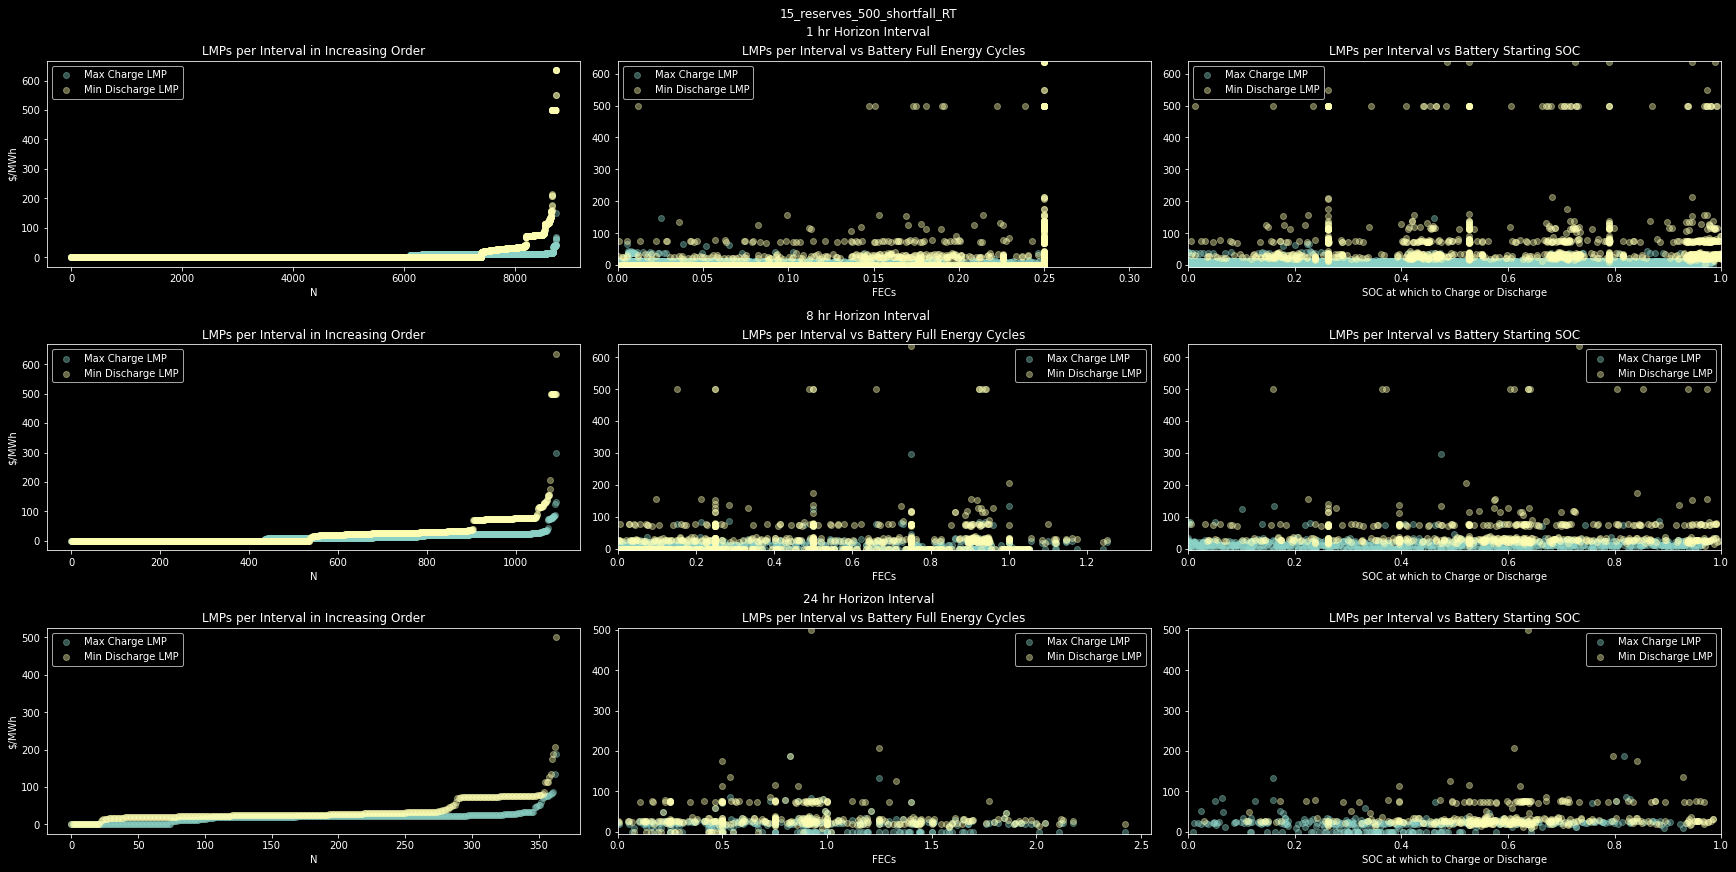

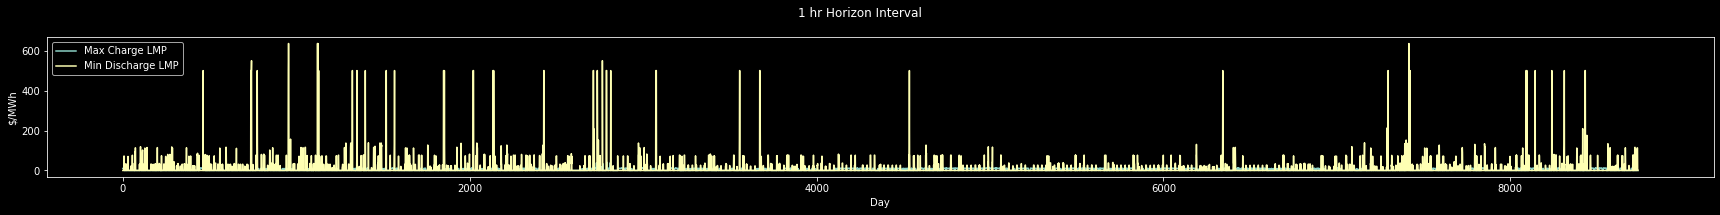

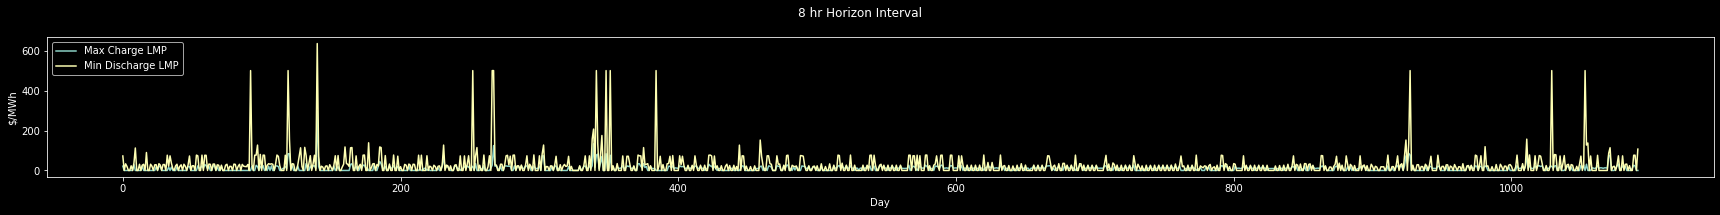

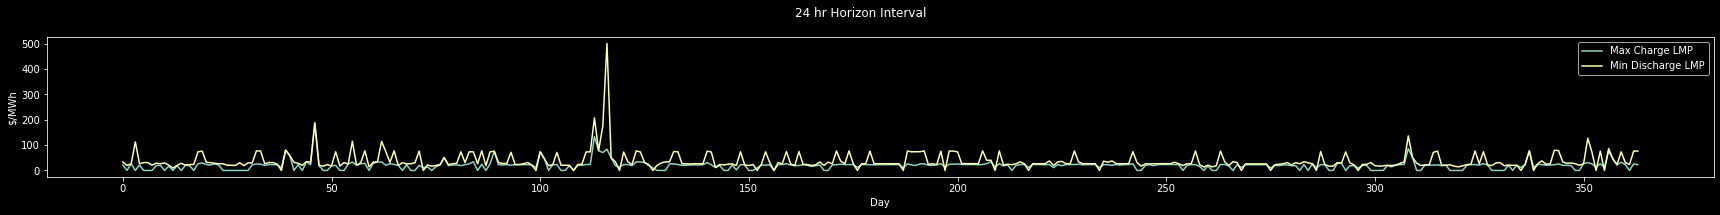

In [55]:
all_batt_plots(dfs[5], names[5])

Assuming the battery charges when LMP < Marginal Cost and Discharges when LMP > Marginal Cost
Break even Charge looks at Marginal Cost Bid where energy charged and discharged over the year is equivalent
Break even Cost looks at Marginal Cost Bid where the actual $/MWh earned is equal to the Required $/MWh to break even on capital investment


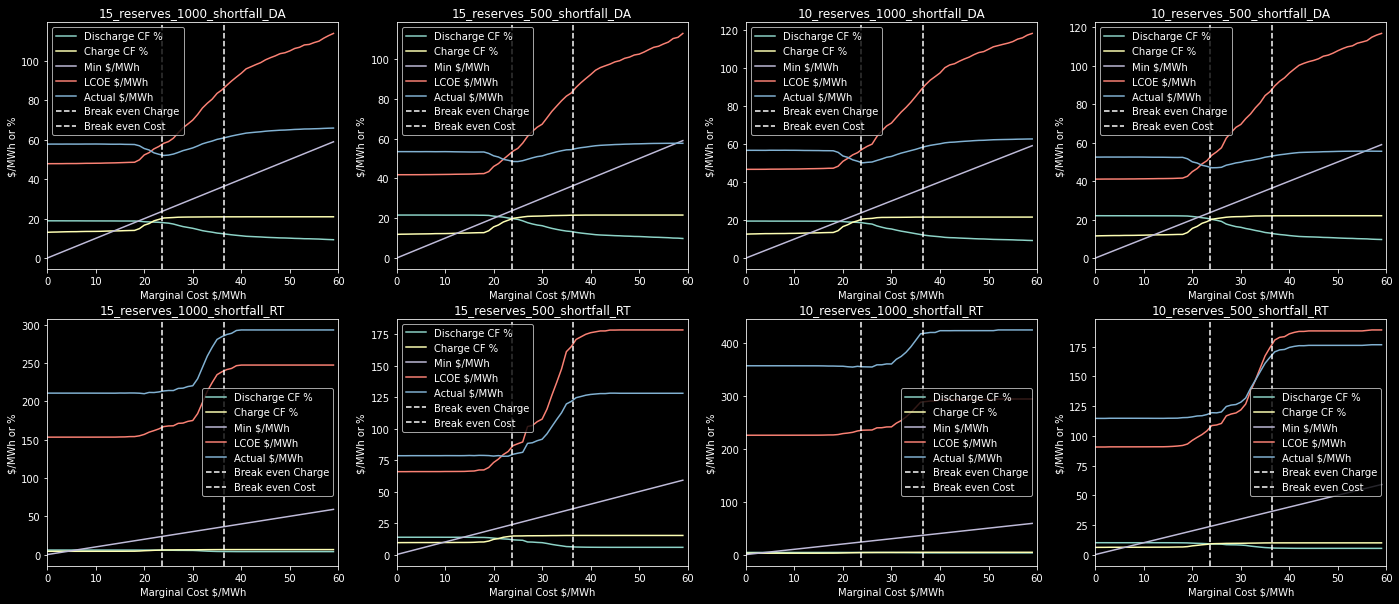

In [79]:
from dispatches.models.renewables_case.load_parameters import batt_cap_cost
# conservative bid curve based more on PPA: revenue at marginal cost >= x vs energy discharged at marginal cost >= x

print("Assuming the battery charges when LMP < Marginal Cost and Discharges when LMP > Marginal Cost")


discount_rate = 0.05
project_years = 30
def levelize(val, i=discount_rate, N=project_years):
    return val * N / (1 + i) ** N

def calc_ppa(rev, mwh, i=discount_rate, N=project_years):
    levelized_rev = levelize(rev, i, N)
    levelized_mwh = levelize(mwh, i, N)
    return levelized_rev / levelized_mwh

def calc_lcoe(mwh, costs, i=discount_rate, N=project_years):
    if type(costs) == float:
        costs = [costs] + [0] * N
    num = sum(costs[n] / (1+i)**n for n in range(N))
    den = sum(mwh[n] / (1+i)**n for n in range(1, N))
    return num/den


def lcoe_vs_marginal_cost(df, marginal_cost):
    """
    Calculates a few Financial numbers that depend on some combination of the marginal cost bid, how much energy is sold, 
    what the cleared LMP is, and the cost of the system

    `ppa_min` (Min $/MWh) is the simply the $/MWh of the energy bid. This is the minimum $/MWh received by the plant
    `ppa_act` (Act $/MWh) is the average, levelized $/MWh of energy sold at the LMPs, often above the marginal cost bid. 
        This is the actual $/MWh received by the plant (of course, holding dispatch steady)
    `lcoe` (LCOE $/MWh) is the cost of discharged battery energy and is the price of energy the system needs to receive 
        per unit dispatched, where the dispatch occurs whenever LMP >= marginal_cost
    `cap_factor` is the capacity factor of discharge
    `charge_cap_factor` is the CF of charging
    """
    batt_mw = df['batt_cap'].unique()[0]
    batt_cost = float(batt_mw * batt_cap_cost) * 1e3
    discharging = df.query(f'batt_to_grid_mw > 0.01 and lmp >= {marginal_cost}')
    discharging_lmps = discharging['lmp'].values
    discharging_mws = discharging['batt_to_grid_mw'].values
    ann_discharge = discharging_mws.sum()
    cap_factor = ann_discharge / batt_mw / 8760
    ann_discharge_rev_min = np.dot(ann_discharge, marginal_cost)
    ann_discharge_rev_act = np.dot(discharging_mws, discharging_lmps)
    # print(ann_discharge, ann_discharge / batt_mw, cap_factor)
    # print("Revenues min vs actual", ann_discharge_rev_min, ann_discharge_rev_act)

    charging = df.query(f'wind_to_batt_mw > 0.01 and lmp <= {marginal_cost}')
    charging_lmps = charging['lmp'].values
    charging_mws = charging['wind_to_batt_mw'].values
    ann_charge = charging_mws.sum()
    charge_cap_factor = ann_charge / batt_mw / 8760
    ann_charge_cost_act = np.dot(charging_mws, charging_lmps)

    ppa_act = calc_ppa(ann_discharge_rev_act - ann_charge_cost_act, ann_discharge)
    ppa_min = calc_ppa(ann_discharge_rev_min, ann_discharge)
    lcoe = calc_lcoe([0] + [ann_discharge] * project_years, [batt_cost] + [ann_charge_cost_act] * project_years)
    # print(ann_discharge_rev_act, ann_charge_cost_act)
    return ppa_min, ppa_act, lcoe, cap_factor * 100, charge_cap_factor * 100

n = int(len(dfs) / 2)
fig, ax = plt.subplots(2, n, figsize=(24, 10))

runs = [
    '15_reserves_1000_shortfall',
    '15_reserves_500_shortfall',
    '10_reserves_1000_shortfall',
    '10_reserves_500_shortfall'
 ]
markets = ['DA', 'RT']

print("Break even Charge looks at Marginal Cost Bid where energy charged and discharged over the year is equivalent")
print("Break even Cost looks at Marginal Cost Bid where the actual $/MWh earned is equal to the Required $/MWh to break even on capital investment")
for n, r in enumerate(runs):
    for m, c in enumerate(markets):
        run_name = r + "_" + c
        df = dfs[names.index(run_name)]

        ppa_min = []
        ppa_act = []
        lcoe = []
        cf_percent = []
        charge_cf_percent = []
        for marginal_cost in range(0, 60):
            res = lcoe_vs_marginal_cost(df, marginal_cost)
            ppa_min.append(res[0])
            ppa_act.append(res[1])
            lcoe.append(res[2])
            cf_percent.append(res[3])
            charge_cf_percent.append(res[4])

        row = 0 if 'DA' in name else 1

        ax[m, n].plot(ppa_min, cf_percent, label="Discharge CF %")
        ax[m, n].plot(ppa_min, charge_cf_percent, label="Charge CF %")
        ax[m, n].plot(ppa_min, ppa_min, label="Min $/MWh")
        ax[m, n].plot(ppa_min, lcoe, label="LCOE $/MWh")
        ax[m, n].plot(ppa_min, ppa_act, label="Actual $/MWh")
        ax[m, n].set_xlim((0, 60))
        ax[m, n].axvline(x=23.7, linestyle='--', label="Break even Charge")
        ax[m, n].axvline(x=36.4, linestyle='--', label="Break even Cost")
        ax[m, n].legend()
        ax[m, n].set_xlabel("Marginal Cost $/MWh")
        ax[m, n].set_ylabel("$/MWh or %")
        # ax[m, n].set_aspect('equal', adjustable='box')
        ax[m, n].set_title(run_name)



In [ ]:
# Not sure how to parametrize RT bid: repeat DA bid or not?
# Since the LMPs are so much higher than DA, DA marginal cost bids is relatively low compared to RT LMPs for shortfall times
# Not sure how well this static parametrized bid curve can "guarantee" energy available for those shortfall times,
# especially since otherwise two market settlement will be highly punishing of missed DA promises


In [91]:
pcm_dfs = []

prescient_sims =  Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/")
for name in names:
    files = glob.glob(str(prescient_sims / f"*_{name[:-3]}" / "Wind_Thermal_Dispatch.csv"))
    if len(files) != 1:
        raise Exception
    df = pd.read_csv(file)
    df["DateTime"] = df['Unnamed: 0']
    df.drop('Unnamed: 0', inplace=True, axis=1)
    df.index = pd.to_datetime(df["DateTime"])
    pcm_dfs.append(df)


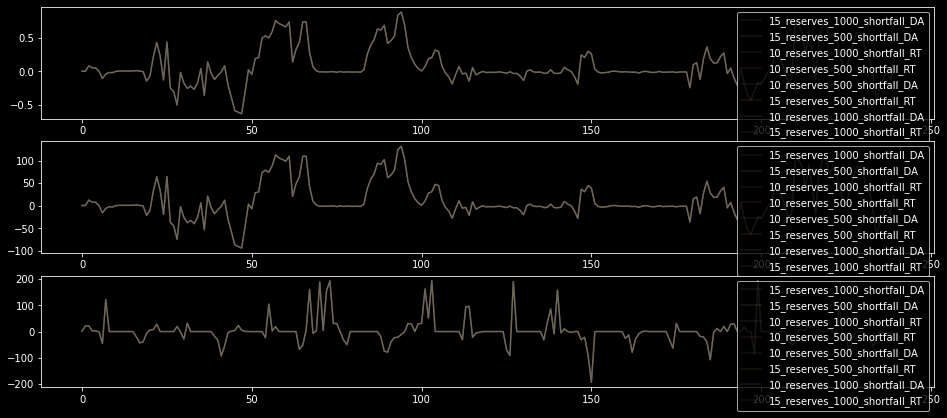

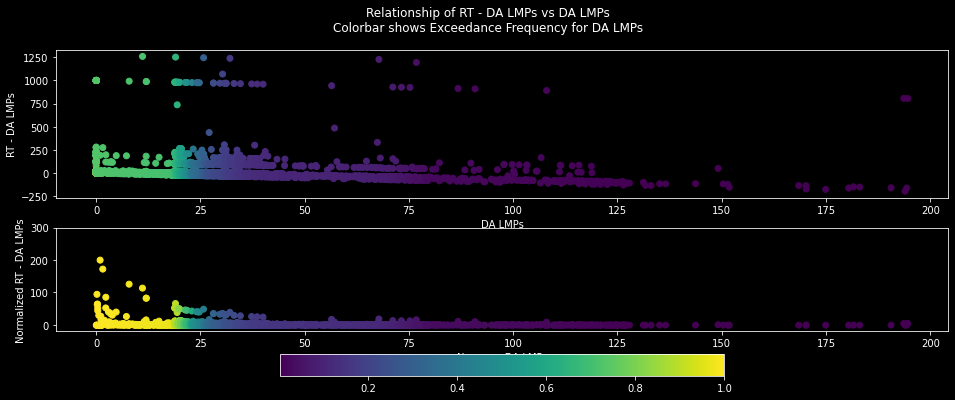

In [78]:
# print(pcm_dfs[0].columns)
cf_diffs = []

fig, ax = plt.subplots(3, 1, figsize=(16, 7))

for name, df in zip(names, pcm_dfs):
    cf_diff = df['309_WIND_1-RTCF'].values - df['309_WIND_1-DACF'].values
    power_diff = df['309_WIND_1-RTPower'].values - df['309_WIND_1-DAPower'].values
    lmp_diff = df['309_RTLMP'].values - df['309_DALMP'].values

    ax[0].plot(cf_diff[0:240], alpha=0.1, label=name)
    ax[1].plot(power_diff[0:240], alpha=0.1, label=name)
    ax[2].plot(lmp_diff[0:240], alpha=0.1, label=name)

    nonzero_DA = df[df['309_DALMP'] > 0]
    nonzero_cf_diff = (nonzero_DA['309_WIND_1-RTCF'].values - nonzero_DA['309_WIND_1-DACF'].values)
    nonzero_power_diff = (nonzero_DA['309_WIND_1-RTPower'] - nonzero_DA['309_WIND_1-DAPower']).values
    nonzero_lmp_diff = ((nonzero_DA['309_RTLMP'] - nonzero_DA['309_DALMP'])/nonzero_DA['309_DALMP']).values


ax[0].legend()
ax[1].legend()
ax[2].legend()

fig, ax = plt.subplots(2, 1, figsize=(16, 6))
sorted_arr = list(zip(df['309_DALMP'].values, lmp_diff))
sorted_arr.sort()
sorted_arr = np.array(sorted_arr)
im = ax[0].scatter(sorted_arr[:, 0], sorted_arr[:, 1], c=1.0 - np.array(range(len(sorted_arr)))/len(sorted_arr))
ax[0].set_xlabel("DA LMPs")
ax[0].set_ylabel("RT - DA LMPs")
fig.suptitle("Relationship of RT - DA LMPs vs DA LMPs\nColorbar shows Exceedance Frequency for DA LMPs")
sorted_arr = list(zip(nonzero_DA['309_DALMP'].values, nonzero_lmp_diff))
sorted_arr.sort()
sorted_arr = np.array(sorted_arr)
im = ax[1].scatter(sorted_arr[:, 0], sorted_arr[:, 1], c=1.0 - np.array(range(len(sorted_arr)))/len(sorted_arr))
ax[1].set_xlabel("Non-zero DA LMPs")
ax[1].set_ylabel("Normalized RT - DA LMPs")
ax[1].set_ylim((-20,300))
fig.colorbar(im, location='bottom')


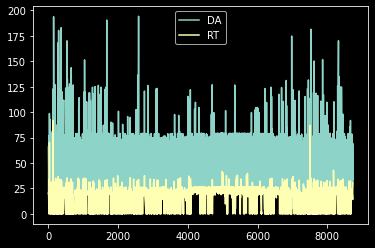

In [87]:
df = pcm_dfs[0]
df = df[df['309_RTLMP'] < df['309_DALMP']]
df['309_DALMP'].plot(label='DA')

df['309_RTLMP'].plot(label='RT')
plt.legend()


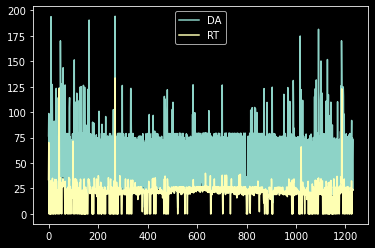

In [93]:
df = pcm_dfs[0]
df = df.resample('4h').max()
df = df[df['309_RTLMP'] < df['309_DALMP']]
plt.plot(df['309_DALMP'].values, label='DA')

plt.plot(df['309_RTLMP'].values, label='RT')
plt.legend()


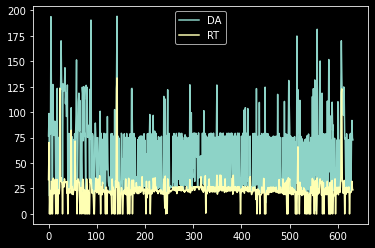

In [94]:
df = pcm_dfs[0]
df = df.resample('8h').max()
df = df[df['309_RTLMP'] < df['309_DALMP']]
plt.plot(df['309_DALMP'].values, label='DA')

plt.plot(df['309_RTLMP'].values, label='RT')
plt.legend()


## Tracking Analysis of the Wind + Battery Using Double Loop

Original Wind Generator, 309_WIND_1, was 148 MW
 - DA: Bids DA forecast
 - RT: Bids RT forecast

Hybrid Wind Generator with Bidding is 200 MW with 25 MW Battery
 - Stochastic Bidder
 - "Parametrized Bidder": thermal capacity ratio of wind, marginal cost of battery capacity
 - "Varying Parametrized Bidder": ratio of DA forecast to reserve for battery, price ratio of RT to DA as marginal cost



In [67]:
def read_double_loop_output(rts_gmlc_dir, bus, gen):
    bus_detail_df = pd.read_csv(rts_gmlc_dir / "bus_detail.csv")
    bus_detail_df['LMP'] = bus_detail_df['LMP'].astype('float64')
    bus_detail_df['LMP DA'] = bus_detail_df['LMP DA'].astype('float64')
    bus_detail_df = bus_detail_df[bus_detail_df['Bus'] == bus]

    start_date = pd.to_datetime(bus_detail_df['Date'].values[0]) + pd.Timedelta(hours=bus_detail_df['Hour'].values[0])
    print(start_date)

    ix = pd.date_range(start=start_date, 
                        end=start_date
                        + pd.offsets.DateOffset(hours=8760),
                        freq='1H')

    bus_detail_df.set_index(ix[:len(bus_detail_df)], inplace=True)


    generator_df = pd.read_csv(rts_gmlc_dir / "thermal_detail.csv")
    generator_df = generator_df[generator_df['Generator'] == gen]
    if len(generator_df):
        generator_df.set_index(ix[:len(generator_df)], inplace=True)
    else:
        generator_df = pd.read_csv(rts_gmlc_dir / "renewables_detail.csv")
        generator_df = generator_df[generator_df['Generator'] == gen]
        generator_df.set_index(ix[:len(generator_df)], inplace=True)

    if (rts_gmlc_dir / "tracker_detail.csv").exists():
        tracker_df = pd.read_csv(rts_gmlc_dir / "tracker_detail.csv")
        tracker_df = tracker_df[tracker_df['Horizon [hr]'] == 0]
        tracker_df.set_index(ix[:len(tracker_df)], inplace=True)

        tracker_model_df = pd.read_csv(rts_gmlc_dir / "tracking_model_detail.csv")
        tracker_model_df = tracker_model_df[tracker_model_df['Horizon [hr]'] == 0]
        tracker_model_df.set_index(ix[:len(tracker_model_df)], inplace=True)
    else:
        tracker_df = None
        tracker_model_df = None

    try:
        summary = pd.read_csv(rts_gmlc_dir / "hourly_summary.csv")
        summary.set_index(ix[0:len(summary)], inplace=True)
    except:
        summary = None

    result_df = pd.concat([bus_detail_df, generator_df, tracker_df, tracker_model_df, summary])
    return result_df

rts_gmlc_dir_orig = Path("/projects/gmihybridsys/dguittet/workspace/deterministic_with_network_simulation_output_year")
orig_results = read_double_loop_output(rts_gmlc_dir_orig, "Carter", "309_WIND_1")
vals = (orig_results['Output DA'] - orig_results['Output']).values / 147 * 200
orig_results['Power Underdelivered [MW]'] = [max(0, i) for i in vals]
orig_results['Power Dispatch [MW]'] = orig_results['Output'] / 147 * 200
orig_results['Power Output [MW]'] = orig_results['Output'] / 147 * 200

rts_gmlc_dir = Path("/projects/gmihybridsys/dguittet/dispatches/sim_0_results")
tracker_df = pd.read_csv(rts_gmlc_dir / "tracker_detail.csv")
tracker_df = tracker_df[tracker_df['Horizon [hr]'] == 0]
start_date = pd.to_datetime(tracker_df['Date'].values[0]) + pd.Timedelta(hours=tracker_df['Hour'].values[0])

ix = pd.date_range(start=start_date, 
                    end=start_date
                    + pd.offsets.DateOffset(hours=8760),
                    freq='1H')
tracker_df.set_index(ix[:len(tracker_df)], inplace=True)

tracker_model_df = pd.read_csv(rts_gmlc_dir / "tracking_model_detail.csv")
tracker_model_df = tracker_model_df[tracker_model_df['Horizon [hr]'] == 0]
tracker_model_df.set_index(ix[:len(tracker_model_df)], inplace=True)
# sto_bid = read_double_loop_output(rts_gmlc_dir, "Carter", "309_WIND_1")
sto_bid = pd.concat([tracker_df, tracker_model_df])

rts_gmlc_dir = Path("/projects/gmihybridsys/dguittet/dispatches/sim_0_Par_results")
param_bid = read_double_loop_output(rts_gmlc_dir, "Carter", "309_WIND_1")

rts_gmlc_dir = Path("/projects/gmihybridsys/dguittet/dispatches/sim_0_Var_results")
varyingp_bid = read_double_loop_output(rts_gmlc_dir, "Carter", "309_WIND_1")

index_intersection = set(orig_results.index).intersection(set(param_bid.index).intersection(set(varyingp_bid.index)))

# get intersection of indices
orig_results = orig_results[orig_results.index.isin(index_intersection)]
param_bid = param_bid[param_bid.index.isin(index_intersection)]
varyingp_bid = varyingp_bid[varyingp_bid.index.isin(index_intersection)]


2020-01-02 00:00:00
2020-01-02 00:00:00
2020-01-02 00:00:00


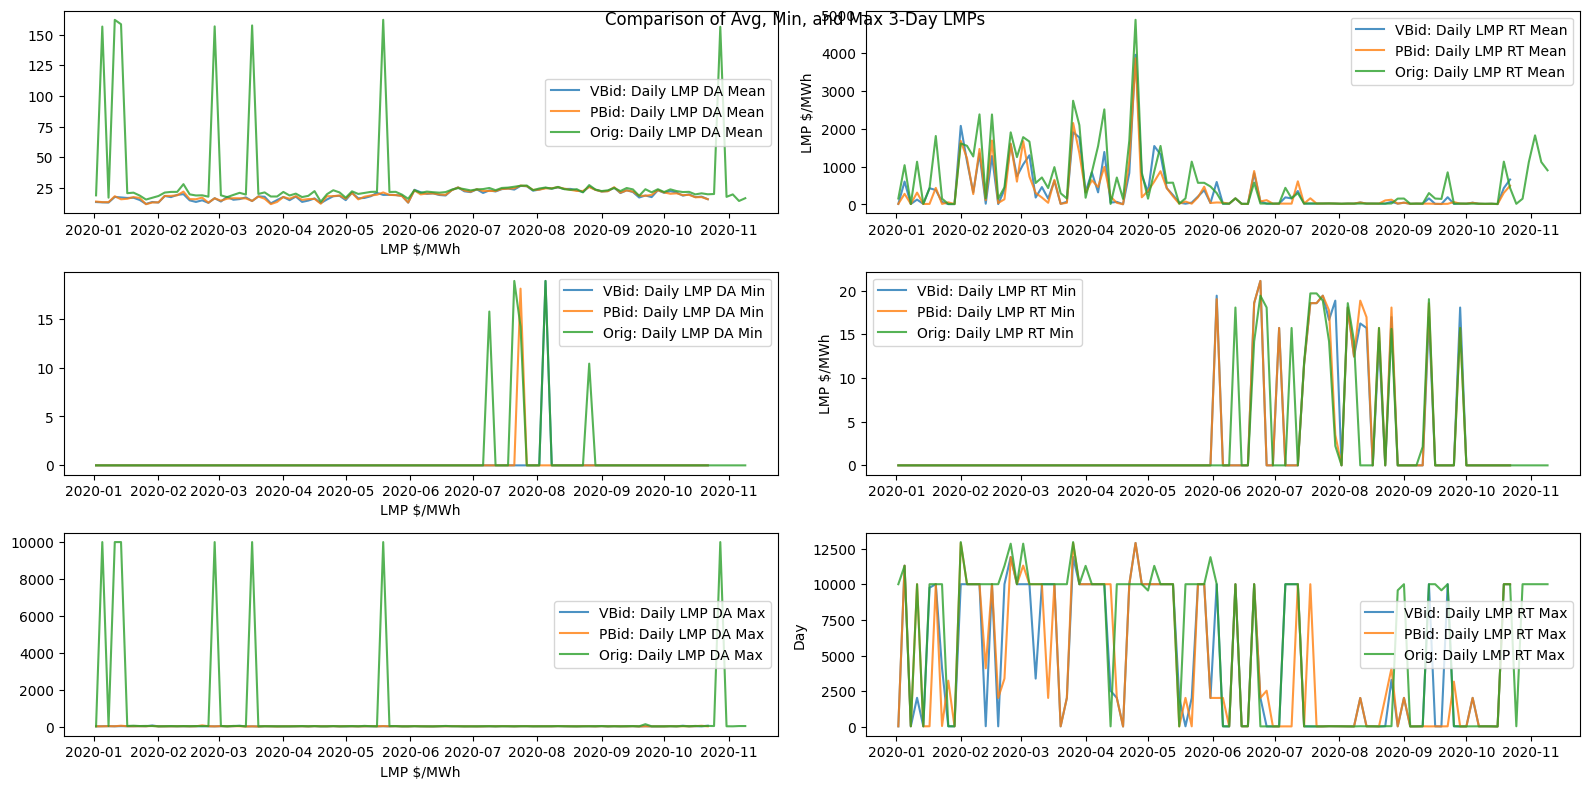

In [68]:
plt.style.use('default')
fig, ax = plt.subplots(3, 2, figsize=(16, 8))

resample_rate = '3D'

varyingp_bid_daily = varyingp_bid[['LMP DA', 'LMP']].resample(resample_rate).mean()
param_bid_daily = param_bid[['LMP DA', 'LMP']].resample(resample_rate).mean()
orig_results_daily = orig_results[['LMP DA', 'LMP']].resample(resample_rate).mean()
n = len(orig_results_daily)
ax[0, 0].plot(varyingp_bid_daily['LMP DA'][0:n], label="VBid: Daily LMP DA Mean", alpha=0.8)
ax[0, 0].plot(param_bid_daily['LMP DA'][0:n], label="PBid: Daily LMP DA Mean", alpha=0.8)
ax[0, 0].plot(orig_results_daily['LMP DA'][0:n], label="Orig: Daily LMP DA Mean", alpha=0.8)
ax[0, 0].set_xlabel("LMP $/MWh")
ax[0, 0].legend()
ax[0, 1].plot(varyingp_bid_daily['LMP'][0:n], label="VBid: Daily LMP RT Mean", alpha=0.8)
ax[0, 1].plot(param_bid_daily['LMP'][0:n], label="PBid: Daily LMP RT Mean", alpha=0.8)
ax[0, 1].plot(orig_results_daily['LMP'][0:n], label="Orig: Daily LMP RT Mean", alpha=0.8)
ax[0, 1].set_ylabel("LMP $/MWh")
ax[0, 1].legend()

varyingp_bid_daily = varyingp_bid[['LMP DA', 'LMP']].resample(resample_rate).min()
param_bid_daily = param_bid[['LMP DA', 'LMP']].resample(resample_rate).min()
orig_results_daily = orig_results[['LMP DA', 'LMP']].resample(resample_rate).min()
ax[1, 0].plot(varyingp_bid_daily['LMP DA'][0:n], label="VBid: Daily LMP DA Min", alpha=0.8)
ax[1, 0].plot(param_bid_daily['LMP DA'][0:n], label="PBid: Daily LMP DA Min", alpha=0.8)
ax[1, 0].plot(orig_results_daily['LMP DA'][0:n], label="Orig: Daily LMP DA Min", alpha=0.8)
ax[1, 0].set_xlabel("LMP $/MWh")
ax[1, 0].legend()
ax[1, 1].plot(varyingp_bid_daily['LMP'][0:n], label="VBid: Daily LMP RT Min", alpha=0.8)
ax[1, 1].plot(param_bid_daily['LMP'][0:n], label="PBid: Daily LMP RT Min", alpha=0.8)
ax[1, 1].plot(orig_results_daily['LMP'][0:n], label="Orig: Daily LMP RT Min", alpha=0.8)
ax[1, 1].set_ylabel("LMP $/MWh")
ax[1, 1].legend()

varyingp_bid_daily = varyingp_bid[['LMP DA', 'LMP']].resample(resample_rate).max()
param_bid_daily = param_bid[['LMP DA', 'LMP']].resample(resample_rate).max()
orig_results_daily = orig_results[['LMP DA', 'LMP']].resample(resample_rate).max()
ax[2, 0].plot(varyingp_bid_daily['LMP DA'][0:n], label="VBid: Daily LMP DA Max", alpha=0.8)
ax[2, 0].plot(param_bid_daily['LMP DA'][0:n], label="PBid: Daily LMP DA Max", alpha=0.8)
ax[2, 0].plot(orig_results_daily['LMP DA'][0:n], label="Orig: Daily LMP DA Max", alpha=0.8)
ax[2, 0].set_xlabel("LMP $/MWh")
ax[2, 0].legend()
ax[2, 1].plot(varyingp_bid_daily['LMP'][0:n], label="VBid: Daily LMP RT Max", alpha=0.8)
ax[2, 1].plot(param_bid_daily['LMP'][0:n], label="PBid: Daily LMP RT Max", alpha=0.8)
ax[2, 1].plot(orig_results_daily['LMP'][0:n], label="Orig: Daily LMP RT Max", alpha=0.8)
ax[2, 1].set_ylabel("LMP $/MWh")
ax[2, 1].set_ylabel("Day")
ax[2, 1].legend()
fig.suptitle("Comparison of Avg, Min, and Max 3-Day LMPs")
fig.tight_layout()

### Compare Production Cost of the System and Unit Market Revenue

20 year NPV is projected using the available days of simulated revenue divided by the capital cost (operating costs are currently ignored)

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Projected 20yr NPV')

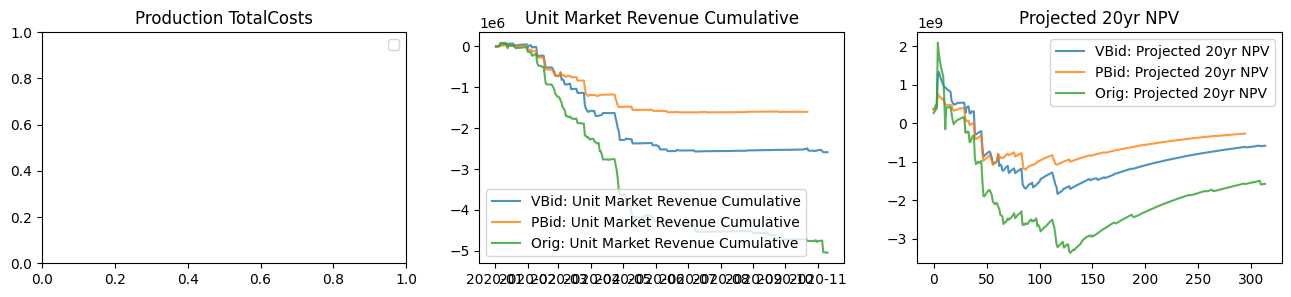

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

varyingp_bid_daily = varyingp_bid.resample('1D').mean()
param_bid_daily = param_bid.resample('1D').mean()
orig_results_daily = orig_results.resample('1D').mean()

# ax[0].plot(varyingp_bid_daily['TotalCosts'].cumsum(), label="PBid: Production TotalCosts")
# ax[0].plot(orig_results_daily['TotalCosts'].cumsum(), label="Orig: Production TotalCosts")
ax[0].legend()
ax[0].set_title("Production TotalCosts")
# ax[1].plot(varyingp_bid_daily['Unit Market Revenue'], label="PBid: Unit Market Revenue")
# ax[1].plot(orig_results_daily['Unit Market Revenue'], label="Orig: Unit Market Revenue")
ax[1].plot(varyingp_bid_daily['Unit Market Revenue'].cumsum(), label="VBid: Unit Market Revenue Cumulative", alpha=0.8)
ax[1].plot(param_bid_daily['Unit Market Revenue'].cumsum(), label="PBid: Unit Market Revenue Cumulative", alpha=0.8)
ax[1].plot(orig_results_daily['Unit Market Revenue'].cumsum(), label="Orig: Unit Market Revenue Cumulative", alpha=0.8)
ax[1].legend()
ax[1].set_title("Unit Market Revenue Cumulative")

def npv(revenues, cap_cost):
    i = 0.05  # discount rate
    N = 30  # years
    PA = ((1 + i) ** N - 1) / (i * (1 + i) ** N)
    year_mults = [365 / i * 20 for i in range(1, len(revenues)+1)]
    return [cap_cost + PA * i * j for i, j in zip(revenues, year_mults)]

year_mult = 365 / len(varyingp_bid_daily) * 20
wind_batt_cap = (200.0 * 1550 + 25.0 * 300 * 4) * 1e3
wind_orig_cap = 148.0 * 1550 * 1e3
ax[2].plot(npv(varyingp_bid_daily['Unit Market Revenue'].cumsum(), wind_batt_cap), label="VBid: Projected 20yr NPV", alpha=0.8)
ax[2].plot(npv(param_bid_daily['Unit Market Revenue'].cumsum(), wind_batt_cap), label="PBid: Projected 20yr NPV", alpha=0.8)
ax[2].plot(npv(orig_results_daily['Unit Market Revenue'].cumsum(), wind_orig_cap), label="Orig: Projected 20yr NPV", alpha=0.8)
ax[2].legend()
ax[2].set_title("Projected 20yr NPV")


### See what the Wind + Battery Unit is doing to Track Dispatch

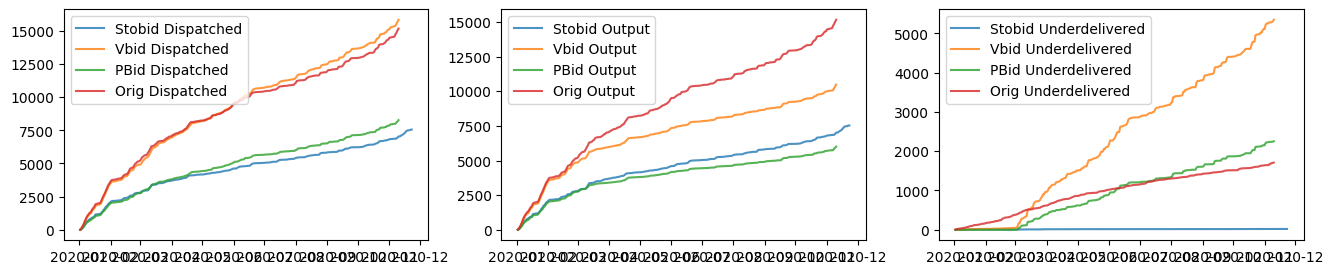

In [70]:
varyingp_bid_daily = varyingp_bid.resample('1D').mean()
param_bid_daily = param_bid.resample('1D').mean()
sto_bid_daily = sto_bid.resample('1D').mean()
orig_results_daily = orig_results.resample('1D').mean()

fig, ax = plt.subplots(1, 3, figsize=(16, 3))
ax[2].plot(sto_bid_daily['Power Underdelivered [MW]'].cumsum(), label="Stobid Underdelivered", alpha=0.8)
ax[2].plot(varyingp_bid_daily['Power Underdelivered [MW]'].cumsum(), label="Vbid Underdelivered", alpha=0.8)
ax[2].plot(param_bid_daily['Power Underdelivered [MW]'].cumsum(), label="PBid Underdelivered", alpha=0.8)
ax[2].plot(orig_results_daily['Power Underdelivered [MW]'].cumsum(), label="Orig Underdelivered", alpha=0.8)
ax[2].legend()

ax[0].plot(sto_bid_daily['Power Dispatch [MW]'].cumsum(), label="Stobid Dispatched", alpha=0.8)
ax[0].plot(varyingp_bid_daily['Power Dispatch [MW]'].cumsum(), label="Vbid Dispatched", alpha=0.8)
ax[0].plot(param_bid_daily['Power Dispatch [MW]'].cumsum(), label="PBid Dispatched", alpha=0.8)
ax[0].plot(orig_results_daily['Power Dispatch [MW]'].cumsum(), label="Orig Dispatched", alpha=0.8)
ax[0].legend()

ax[1].plot(sto_bid_daily['Power Output [MW]'].cumsum(), label="Stobid Output", alpha=0.8)
ax[1].plot(varyingp_bid_daily['Power Output [MW]'].cumsum(), label="Vbid Output", alpha=0.8)
ax[1].plot(param_bid_daily['Power Output [MW]'].cumsum(), label="PBid Output", alpha=0.8)
ax[1].plot(orig_results_daily['Power Output [MW]'].cumsum(), label="Orig Output", alpha=0.8)
ax[1].legend()
# ax[0].plot(orig_results_daily['Power Underdelivered [MW]'])

